In [1]:
%cd ..

/home/dawood/Workspace/compoundGAN


In [2]:
import torch
import joypy
import dgl
import random
import networkx as nx
import numpy as np

from tqdm.notebook import tqdm 
from collections import defaultdict

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem.Fingerprints import FingerprintMols
from PIL import Image

import selfies
from selfies import encoder as selfies_encoder
from selfies import decoder as selfies_decoder
from data.selfies import SELFIES, SELFIE_VOCAB, SELFIES_STEREO

from models.network import CVAEF

from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

DEVICE = torch.device('cpu')

random.seed(42)

In [3]:
dataset = SELFIES('/home/dawood/Datasets/ZINC250K/data.csv')
dataset_smiles = []
dataset_logP = []
for smiles in tqdm(dataset.data):
    mol = Chem.MolFromSmiles(smiles)
    Chem.Kekulize(mol)
    smiles = Chem.CanonSmiles(Chem.MolToSmiles(mol))
    dataset_smiles.append(smiles)
    
    logP = Descriptors.MolLogP(mol)
    dataset_logP.append(logP)

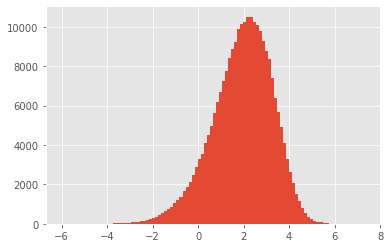

In [4]:
plt.hist(dataset_logP, bins=100)
plt.show()

In [5]:
#state_dict = torch.load('/home/dawood/Experiments/compound-gan-c7f57372210a4de2a2af310e75c54d4f/model_76.weights', map_location='cpu')#
#state_dict = torch.load('/home/dawood/Experiments/compound-gan-0f740abcf5244a9d91ad75689c747fcb/model_177.weights', map_location='cpu')#
#state_dict = from tqdm.notebook import trange, tqdmtorch.load('/home/dawood/Experiments/compound-gan-9657e4bc21494989a3ab04e2e973deb7/model_29.weights', map_location='cpu')
#state_dict = torch.load('/home/dawood/Experiments/compound-gan-c9f3638c8cb1488ab503d28fea2d4752/model_80.weights', map_location='cpu')
state_dict = torch.load('./model.weights', map_location='cpu')#.weights')
print(state_dict['epoch'], state_dict['seq_len'])
seq_len = state_dict['seq_len']
seq_len = 64 if seq_len == np.inf else seq_len

733 inf


In [6]:
D = 256
L = D
model = CVAEF([81, 3], D,
              [L, L, L, L], 1, 0.9, True, use_adjoint=False, num_decoder_layers=4)
model.load_state_dict(state_dict['parameters'])
model = model.eval().to(DEVICE)

In [7]:
def pred2smiles(x):
    seq = []
    for (i, j) in zip(x[:, :81].argmax(-1).long().tolist(), x[:, 81:].argmax(-1).long().tolist()):
        t = SELFIE_VOCAB[i]
        s = SELFIES_STEREO[j]

        if i != 0 and i != 1:
            t = '[' + s + t[1:]

        seq.append(t)

        if i == 1:
            break
        
    selfie = ''.join(seq)
    smiles = selfies.decoder(selfie.replace('[START]', '').replace('[END]', ''))
    
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        Chem.SanitizeMol(mol, catchErrors=False)
        smiles = Chem.MolToSmiles(mol)
        return smiles, mol
    except Exception as e:
        print('MOL ERROR : ', e)
    
    return '', None
                
def reconstruct(smiles, draw=True, deterministic=False, seq_len=100):
    mol = Chem.MolFromSmiles(smiles)
    G = mol2graph(mol)[0]
    G.to(DEVICE)
        
    mu, var = model.encoder(G)
    if not deterministic:
        z = model.reparameterize(mu, var).unsqueeze(0)
    else:
        z = mu.unsqueeze(0)
            
    G = model.decoder.generate(z, seq_len)

    pred_mol = graph2mol(G)
    
    fp_gt   = FingerprintMols.FingerprintMol(mol)
    fp_pred = FingerprintMols.FingerprintMol(pred_mol)
    similarity = DataStructs.FingerprintSimilarity(fp_gt, fp_pred)
    
    try:
        Chem.SanitizeMol(pred_mol, catchErrors=False)
        valid = 1
    except Exception as e:
        print(e)
        valid = 0
      
    if draw:
        try:
            img = Draw.MolsToGridImage([mol, pred_mol], molsPerRow=2, subImgSize=(400, 400), legends=['GT', 'Pred'])
            plt.figure(figsize=(8, 8))
            plt.imshow(img, interpolation='bilinear')
        except Exception as e:
            Draw.MolToMPL(mol, size=(250, 250)); 
            
        plt.axis('off')
        plt.show()
    
    return z, valid, similarity#edge_list, node_list, z, valid, similarity

def generate_random(num_mols, draw=True):

    pred_smiles = []
    pred_mols   = []
    logP_data   = []

    for i in tqdm(range(num_mols//32)):
        z = torch.zeros((32, D-1))
        logP = torch.zeros((32, 1))
        for j in range(len(z)):
            z[j].normal_(0, 1)
            logP[j].uniform_(0, 1)
            logP[j] = ((logP[j] - 0.5) * 12).int().float()
        
        z = torch.cat([z, logP], -1)
        z = z.to(DEVICE)
        z = model.cnf(z, None, True)[0]

        pred = model.decoder.generate(z, seq_len)
        
        for b in range(pred.shape[1]):
            smiles, mol = pred2smiles(pred[:, b])
            if mol is not None:
                pred_mols.append(mol)
                pred_smiles.append(Chem.CanonSmiles(Chem.MolToSmiles(mol)))
                pred_logP = Chem.Descriptors.MolLogP(mol)
                logP_data.append((logP[b].item(), pred_logP))
    
    num_mols = len(pred_mols)

    if draw:
        img = Draw.MolsToGridImage(pred_mols, molsPerRow=4, subImgSize=(400, 400))
        plt.figure(figsize=(num_mols*2, num_mols*2))
        plt.imshow(img, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    
    return pred_mols, pred_smiles, logP_data

In [8]:
pred_mols, pred_smiles, logP_data = generate_random(1_000, draw=False)

MOL ERROR :  Sanitization error: Explicit valence for atom # 10 N, 5, is greater than permitted
MOL ERROR :  Sanitization error: Explicit valence for atom # 13 O, 3, is greater than permitted
MOL ERROR :  Sanitization error: Explicit valence for atom # 12 N, 4, is greater than permitted
invalid literal for int() with base 10: '3]'
Could not decode selfies string. Please contact authors.
MOL ERROR :  No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type int
MOL ERROR :  Sanitization error: Explicit valence for atom # 11 O, 3, is greater than permitted
MOL ERROR :  Sanitization error: Explicit valence for atom # 6 N, 4, is greater than permitted
MOL ERROR :  Sanitization error: Explicit valence for atom # 27 O, 3, is greater than permitted
MOL ERROR :  Sanitization error: Explicit valence for atom # 0 N, 4, is greater than permitted
MOL ERROR :  Sanitization

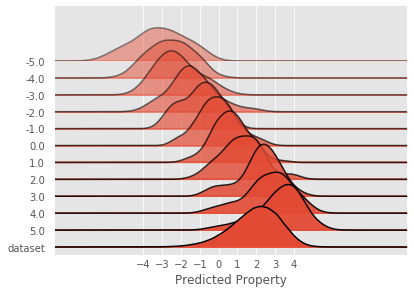

In [9]:
logP_map = defaultdict(list)
for i in sorted(logP_data, key=lambda x:x[0]):
    logP_map[i[0]].append(i[1])
logP_map['dataset'] = dataset_logP
joypy.joyplot(logP_map, grid=True, fade=True)#, labels=keys)
plt.xticks(range(-4, 5))
plt.xlabel('Predicted Property')
plt.ylabel('Requested Property')
plt.show()

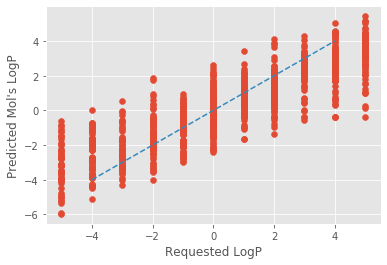

In [10]:
plt.figure()
plt.scatter([i[0] for i in logP_data], [i[1] for i in logP_data])
plt.plot([-4, 4], [-4, 4], 'C1--')

plt.xlabel('Requested LogP')
plt.ylabel('Predicted Mol\'s LogP')
plt.show()

In [11]:
novel_smiles = []
for p_smiles in set(pred_smiles):
    if p_smiles not in dataset_smiles:
        novel_smiles.append(p_smiles)

In [12]:
len(pred_smiles), len(set(pred_smiles)), len(set(novel_smiles))

(881, 856, 856)

In [82]:
idx = torch.randint(len(dataset)//2, len(dataset), (1,))
smiles = dataset.data[idx]

valids = []
scores = []
for i in range(10):
    z, v, s = reconstruct(smiles, deterministic=False)
    valids.append(v)
    scores.append(s)
    #break
    
print(valids, scores)
print(torch.tensor(valids, dtype=float).mean().item(), torch.tensor(scores, dtype=float).mean().item())

NameError: name 'mol2graph' is not defined

In [ ]:
plt.figure(figsize=(32, 32))
run('')

In [ ]:
idx = torch.randint(len(dataset)//2, len(dataset), (1,))
#idx = 20
smiles = dataset.data[idx]
mol = Chem.MolFromSmiles(smiles)
Draw.MolToMPL(mol); plt.show()
#edge_list, node_list, emb, valid, similarity = run_network(smiles)
G = run(smiles)

In [ ]:
#smiles = 'C(=O)C=CCC=C'
#smiles = 'C'
smiles='CC(=O)NC1=CC=CC=C1C(=O)O'
#reconstruct(smiles)
# smiles='C1=CC=C(C(=C1)C(=O)OC2=CC=CC=C2C(=O)O)O'
# smiles='CCC[NH2+]C1CCC(O)(Cc2nc(C)cs2)CC1'
# smiles='C#CCOCC1CCN(C(=O)c2ccc(S(=O)(=O)N3CCCC[C@H]3C)cc2)CC1'
# smiles='Cc1cccc2sc(NC(=O)[C@H](C)N3C(=O)[C@@H]4CC=CC[C@H]4C3=O)nc12'
# smiles='Cc1cc(C(=O)Nc2ccc(OCC(N)=O)cc2)c(C)n1C1CC1'
# smiles='CCOc1ccc2nc(N(C[C@@H]3CCCO3)C(=O)c3ccccc3S(C)(=O)=O)sc2c1'
# smiles='COc1cc(C(=O)N(Cc2cccc(F)c2)[C@H]2CCS(=O)(=O)C2)cc(OC)c1OC'
mol = Chem.MolFromSmiles(smiles)
Draw.MolToMPL(mol); plt.show()
#G = mol2graph(mol)[0]
#G.to(DEVICE)
#mu, var = enc(G)
run(smiles)

In [ ]:
mol